# Machine Learning in Python - Project 1

Due Friday, March 11th by 5 pm.

*include contributors names here*

## 0. Setup

In [193]:
#%%
#os library version
from pathlib import Path

# Data libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import seaborn as sns

# sklearn modules
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split


# extra modules
from schrutepy import schrutepy

##Global variables
##Threshold total line percentage for being a "main character"
P = 0.005



## 1. Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a client). If you use any additional data sources, you should introduce them here and discuss why they were included.*

*Briefly outline the approaches being used and the conclusions that you are able to draw.*

## 2. Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.*

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data. Specifically, this should be any code that you use to generate new columns in the data frame `d`. All of this processing is explicitly meant to occur before we split the data in to training and testing subsets. Processing that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

*All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.*

In [194]:
##Load Data
d = pd.read_csv("../the_office.csv")
transcripts = schrutepy.load_schrute()



In [204]:
##copy original data so we don't lose it
df = d.copy()

##Note that some directors are repeated with different spellings. 
##Need to fix before any future data solutions
wrongdir_dict = {"Greg Daneils": "Greg Daniels", "Charles McDougal": "Charles McDougall",
                 "Claire Scanlong":"Claire Scanlon"}
df["director"].replace(wrongdir_dict, inplace=True)

In [205]:
df.head()

,season,episode,episode_name,director,writer,imdb_rating,total_votes,air_date,n_lines,n_directions,n_words,n_speak_char,main_chars
0,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,7.6,3706,2005-03-24,229,27,2757,15,Angela;Dwight;Jim;Kevin;Michael;Oscar;Pam;Phyl...
1,1,2,Diversity Day,Ken Kwapis,B.J. Novak,8.3,3566,2005-03-29,203,20,2808,12,Angela;Dwight;Jim;Kelly;Kevin;Michael;Oscar;Pa...
2,1,3,Health Care,Ken Whittingham,Paul Lieberstein,7.9,2983,2005-04-05,244,21,2769,13,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...
3,1,4,The Alliance,Bryan Gordon,Michael Schur,8.1,2886,2005-04-12,243,24,2939,14,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...
4,1,5,Basketball,Greg Daniels,Greg Daniels,8.4,3179,2005-04-19,230,49,2437,18,Angela;Darryl;Dwight;Jim;Kevin;Michael;Oscar;P...


In [206]:
df.info() #no missing values :)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   season        186 non-null    int64  
 1   episode       186 non-null    int64  
 2   episode_name  186 non-null    object 
 3   director      186 non-null    object 
 4   writer        186 non-null    object 
 5   imdb_rating   186 non-null    float64
 6   total_votes   186 non-null    int64  
 7   air_date      186 non-null    object 
 8   n_lines       186 non-null    int64  
 9   n_directions  186 non-null    int64  
 10  n_words       186 non-null    int64  
 11  n_speak_char  186 non-null    int64  
 12  main_chars    186 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 19.0+ KB


In [207]:
lowest_rating = df["imdb_rating"].min()
highest_rating = df["imdb_rating"].max()
f"The Lowest and Highest IMDB Rating for The Office is {lowest_rating} and {highest_rating}"

'The Lowest and Highest IMDB Rating for The Office is 6.7 and 9.7'

In [208]:
object_col = df.columns[d.dtypes == "object"].tolist()
df.loc[:,object_col]

,episode_name,director,writer,air_date,main_chars
0,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,2005-03-24,Angela;Dwight;Jim;Kevin;Michael;Oscar;Pam;Phyl...
1,Diversity Day,Ken Kwapis,B.J. Novak,2005-03-29,Angela;Dwight;Jim;Kelly;Kevin;Michael;Oscar;Pa...
2,Health Care,Ken Whittingham,Paul Lieberstein,2005-04-05,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...
3,The Alliance,Bryan Gordon,Michael Schur,2005-04-12,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...
4,Basketball,Greg Daniels,Greg Daniels,2005-04-19,Angela;Darryl;Dwight;Jim;Kevin;Michael;Oscar;P...
...,...,...,...,...,...
181,Stairmageddon,Matt Sohn,Dan Sterling,2013-04-11,Andy;Angela;Creed;Dwight;Erin;Jim;Kevin;Meredi...
182,Paper Airplane,Jesse Peretz,Halsted Sullivan;Warren Lieberstein,2013-04-25,Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kevin...
183,Livin' the Dream,Jeffrey Blitz,Nicki Schwartz-Wright,2013-05-02,Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kevin...
184,A.A.R.M,David Rogers,Brent Forrester,2013-05-09,Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kevin...


We see that the columns writer and main_chars are str but should be treated as list of strings, we might need to convert them into binary variables later as well.(think one-hot encoding)
air_date could be separated into year month and day number.
We are not sure about episode_name and director columns

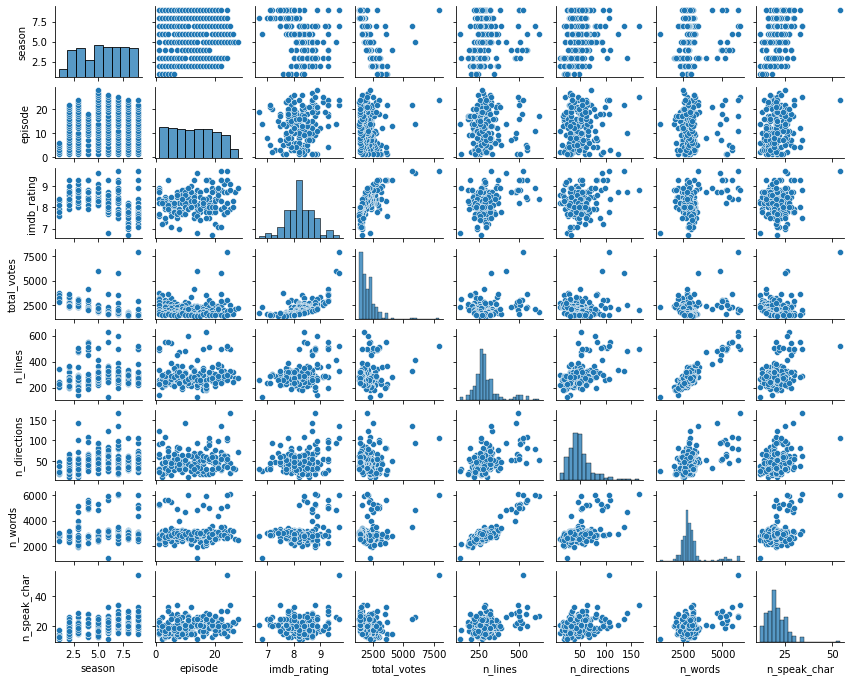

In [209]:
#checking correlations between features 
sns.pairplot(df, height=1.2, aspect=1.25)

The only features have that a slight correlation are n_words and n_lines, which makes sense since number of lines are dependant on the number of words spoken.

<AxesSubplot:xlabel='imdb_rating', ylabel='Count'>

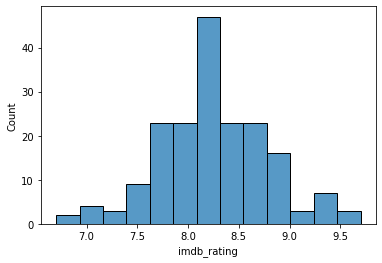

In [210]:
sns.histplot(data=df,x="imdb_rating")

Since, the histogram does look normal, we are going to verify it using the Shapiro-Wilk test.

In [202]:
#some more testing to check for normality
from scipy.stats import shapiro

stat, p = shapiro(df["imdb_rating"])
print(stat,p)

#since p value is not less than alpha=0.05,
#we fail to reject the null hypothesis,i.e data is normal

0.9880892038345337 0.12033943086862564


The Shapiro Wilk test suggests the Imdb ratings data is normal, since the p-value is not less than alpha=0.05. We-fail to reject the null hypothesis, which says the data is a normal distribution.

58


C:\Users\ANOUSHKA\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


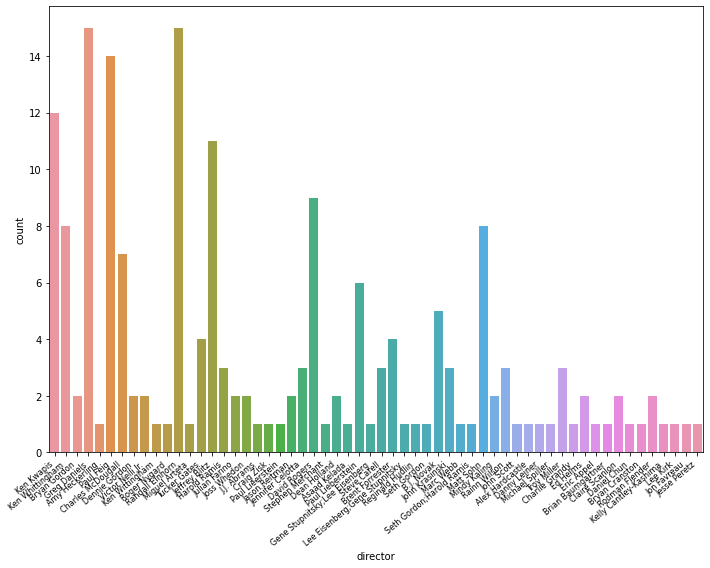

In [211]:
#gets all the unique names of directors
directors = df["director"]
print(directors.nunique())

#counts the number of episodes directors have directed
plt.figure(figsize=(10,8))
ax = sns.countplot(directors)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right",fontsize=8)
plt.tight_layout()
plt.show()

The main directors who have directed more than 6 episodes are Ken Kwapis,Ken Whittingham,Greg Daniels,Paul Feig,Charles McDougall,Randall Einhorn,Jeffrey Blitz,David Rogers and Matt Sohn.

47


C:\Users\ANOUSHKA\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


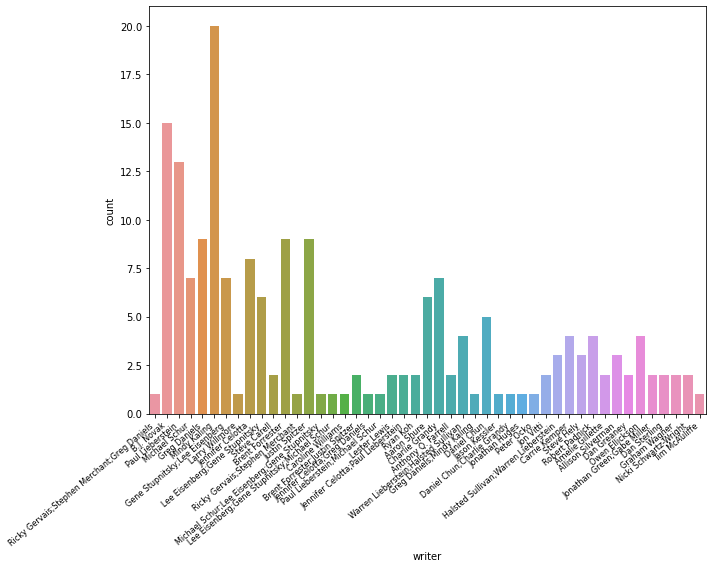

In [212]:
#gets the unique writers in the data
writers = df["writer"]
print(writers.nunique())

#countplot for the number of episodes writer has written
plt.figure(figsize=(10,8))
ax = sns.countplot(writers)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right",fontsize=8)
plt.tight_layout()
plt.show()

The main writers who have written more than 10 episodes are B.J.Novak, Paul Lieberstein and Mindy Kaling.

Here, we are checking for the 10 highest rated episodes.

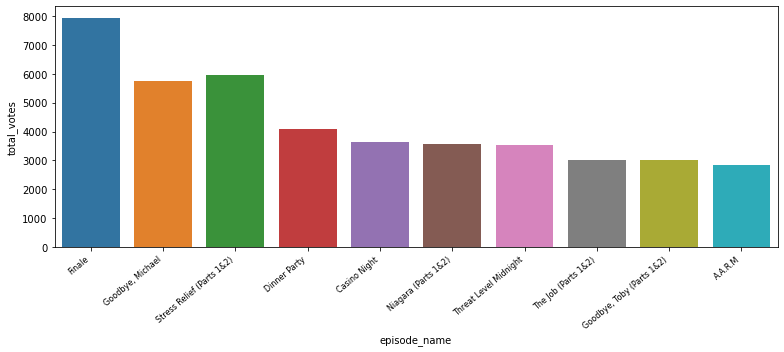

In [213]:
top_rated = df.sort_values(by=["imdb_rating","total_votes"],ascending=False).head(10) #the top 10 rated episodes

plt.figure(figsize=(11, 5))
ax1 = sns.barplot(x= 'episode_name',y= 'total_votes',data=top_rated)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right",fontsize=8)
plt.tight_layout()
plt.show()

Now, We find the 10 lowest-rated Episodes.

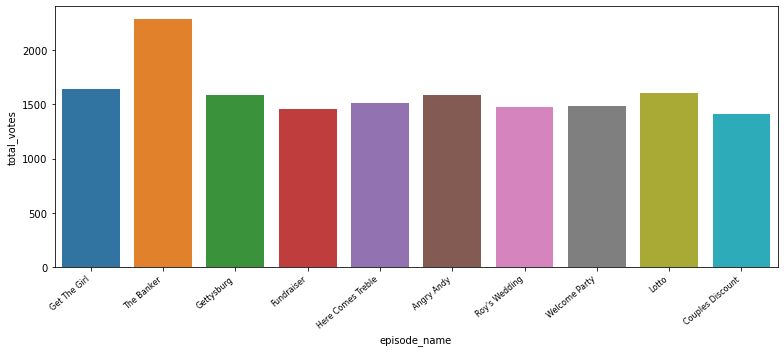

In [214]:
lowest_rated = df.sort_values(by=["imdb_rating","total_votes"]).head(10) #the lowest 10 rated episodes

plt.figure(figsize=(11, 5))
ax1 = sns.barplot(x= 'episode_name',y= 'total_votes',data=lowest_rated)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right",fontsize=8)
plt.tight_layout()
plt.show()

In [215]:
writers_avg_rating = df.groupby("writer")['imdb_rating'].mean().reset_index()

best_writers= writers_avg_rating.sort_values("imdb_rating",ascending= False).head(10)
best_writers

,writer,imdb_rating
37,Paul Lieberstein;Michael Schur,9.300000
17,Greg Daniels;Mindy Kaling,9.300000
22,Jennifer Celotta;Paul Lieberstein,9.100000
21,Jennifer Celotta;Greg Daniels,9.100000
43,Steve Carell,8.800000
29,Lee Eisenberg;Gene Stupnitsky;Michael Schur,8.800000
16,Greg Daniels,8.744444
30,Lester Lewis,8.600000
32,Michael Schur;Lee Eisenberg;Gene Stupnitsky,8.600000
23,Jon Vitti,8.550000


Checking for the highest rated seasons

<AxesSubplot:xlabel='season', ylabel='imdb_rating'>

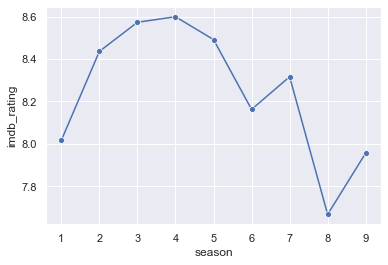

In [216]:
season_avg_rating = df.groupby("season")["imdb_rating"].mean().reset_index()

sns.set_theme(style="darkgrid")
sns.lineplot(data=season_avg_rating,x="season",y="imdb_rating",marker="o")

From the above linegraph, we can see a rise in ratings from season 1 to season 4, then a dip from season 4 to season 6, a slight rise for season 7 and a steep decline for season 8 and a rise for season 9.

In [217]:
print( "director cells with more than 1 element:",sum([len(x) > 1 for x in d.director.apply(lambda x:x.split(";"))]))
print( "episode_name cells with more than 1 element:",sum([len(x) > 1 for x in d.episode_name.apply(lambda x:x.split(";"))]))

director cells with more than 1 element: 3
episode_name cells with more than 1 element: 0


Only director need to be treat as lists. We will do that in the next cell.

In [218]:
#Let's separate these columns
# create df as a copy of d
df = d.copy()

df[["year", "month", "day"]] = pd.DataFrame(d.air_date.str.split("-").tolist()).astype(int)
df["writer"]                 = df["writer"].str.split(";")
df["main_chars"]             = df["main_chars"].str.split(";")
df["director"]               = df["director"].str.split(";")
df

,season,episode,episode_name,director,writer,imdb_rating,total_votes,air_date,n_lines,n_directions,n_words,n_speak_char,main_chars,year,month,day
0,1,1,Pilot,[Ken Kwapis],"[Ricky Gervais, Stephen Merchant, Greg Daniels]",7.6,3706,2005-03-24,229,27,2757,15,"[Angela, Dwight, Jim, Kevin, Michael, Oscar, P...",2005,3,24
1,1,2,Diversity Day,[Ken Kwapis],[B.J. Novak],8.3,3566,2005-03-29,203,20,2808,12,"[Angela, Dwight, Jim, Kelly, Kevin, Michael, O...",2005,3,29
2,1,3,Health Care,[Ken Whittingham],[Paul Lieberstein],7.9,2983,2005-04-05,244,21,2769,13,"[Angela, Dwight, Jim, Kevin, Meredith, Michael...",2005,4,5
3,1,4,The Alliance,[Bryan Gordon],[Michael Schur],8.1,2886,2005-04-12,243,24,2939,14,"[Angela, Dwight, Jim, Kevin, Meredith, Michael...",2005,4,12
4,1,5,Basketball,[Greg Daniels],[Greg Daniels],8.4,3179,2005-04-19,230,49,2437,18,"[Angela, Darryl, Dwight, Jim, Kevin, Michael, ...",2005,4,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,9,19,Stairmageddon,[Matt Sohn],[Dan Sterling],8.0,1484,2013-04-11,273,59,2965,24,"[Andy, Angela, Creed, Dwight, Erin, Jim, Kevin...",2013,4,11
182,9,20,Paper Airplane,[Jesse Peretz],"[Halsted Sullivan, Warren Lieberstein]",8.0,1482,2013-04-25,234,48,2564,27,"[Andy, Angela, Creed, Darryl, Dwight, Erin, Ji...",2013,4,25
183,9,21,Livin' the Dream,[Jeffrey Blitz],[Nicki Schwartz-Wright],8.9,2041,2013-05-02,382,33,4333,20,"[Andy, Angela, Creed, Darryl, Dwight, Erin, Ji...",2013,5,2
184,9,22,A.A.R.M,[David Rogers],[Brent Forrester],9.3,2860,2013-05-09,501,54,4965,30,"[Andy, Angela, Creed, Darryl, Dwight, Erin, Ji...",2013,5,9


In [219]:
#searching for Episodes with parts that are grouped together
p = re.compile("Parts 1&2")
df["multi_part"] = [not pd.isnull(re.search(p,i)) for i in df["episode_name"]]

p = re.compile("Part [12]")
df[[not pd.isnull(re.search(p,i)) for i in df["episode_name"]]]

,season,episode,episode_name,director,writer,imdb_rating,total_votes,air_date,n_lines,n_directions,n_words,n_speak_char,main_chars,year,month,day,multi_part
78,5,16,Lecture Circuit (Part 1),[Ken Kwapis],[Mindy Kaling],8.2,1838,2009-02-05,237,52,2792,14,"[Andy, Creed, Dwight, Jim, Kelly, Michael, Osc...",2009,2,5,False
79,5,17,Lecture Circuit (Part 2),[Ken Kwapis],[Mindy Kaling],8.2,1808,2009-02-12,252,60,2412,17,"[Angela, Creed, Dwight, Jim, Kelly, Kevin, Mer...",2009,2,12,False


In [ ]:
#numerical columns
df.select_dtypes(include=np.number).columns.tolist()

In [149]:
##combining transcript data with original data to get character line information/important characters

##string cols
str_cols = (transcripts.applymap(type) == str).all(0)

##Lower names, character's and lines for easier processing
transcripts = transcripts.applymap(lambda s: s.lower() if type(s) == str else s)

##Remove spaces in character (some are incorrectly written like "jim ")
transcripts['character'] = transcripts['character'].str.replace(" ", "")
transcripts['season_ep'] = transcripts['season'].astype(str) + "_" + transcripts['episode'].astype(str)

# ##Per Episode Character lines
# transcripts.character.unique()
line_sum = transcripts.groupby(["season_ep", "character"]).size().reset_index(name = "lines") ##per character and episode lines
line_sum = line_sum.sort_values(ascending = False, by = "lines")##sort by lines

##Total line percentage per character
line_perc = line_sum.groupby("character").agg({"lines": "sum"}).sort_values(ascending = False, by = "lines")
line_perc['percentage'] = line_perc/(line_perc.sum())

##Greater than 1% line share
main_char = line_perc.loc[line_perc['percentage'] > P].index

##Top 10 line speakers (main_char)
# main_char = (line_perc.nlargest(10, 'percentage')).index

##per episode lines for main characters
line_main = line_sum.loc[line_sum['character'].isin(main_char)]

##Join main data with lines per character data

##convert line data into dataframe with each row as a season/episode and each column as the main character lines
char_lines = line_main.pivot_table(values='lines', index='season_ep', columns='character').reset_index()
char_lines = char_lines.fillna(0) ##fill NA values with zero because they are only not present if no lines were spoken

##calculate character line percentage per episode
perc_cols = char_lines.select_dtypes(include=np.number).columns + "_perc" ##create column names
char_lines[perc_cols] = char_lines.select_dtypes(include=np.number).div(d.n_lines, axis = 0) ##per row char line percentages

##Create character dummy variables for if present
main_char_dummy = [str(x) + "_dummy" for x in main_char]
char_lines[main_char_dummy] = (char_lines[main_char] > 0).astype(int)

##create season_ep column for d to join by
df['season_ep'] = df['season'].astype(str) + "_" + df['episode'].astype(str)

##join the main data with the lines per character data
df = pd.merge(df, char_lines, on = 'season_ep', how = 'left')


In [150]:
##Want to get a list of all writers and a list of all directors 
##Create new columns where the presence of each writer is it's own variable (one-hot encoding)

# convert string to lists
#df[["year", "month", "day"]] = pd.DataFrame(d.air_date.str.split("-").tolist()).astype(int)
df["writer"]                 = df["writer"].str.split(";")
df["main_chars"]             = df["main_chars"].str.split(";")
df["director"]               = df["director"].str.split(";")

##Now create dummy variables for each of the writers/directors (we are dropping main character dummies)

#######################################################################################################
##Functions to Modify Writer/Director##

##Function to split column with list variables into dummy variable columns
def split_col(column, df):
    ##For each episode, check which writiers or directosr are present and put into a dictionary
    ##Each column is a writer/direction; each row is an episode
    ##The value of row, column is T/F for whether a writer/director is present
    
    ##get all writers/directors in a flat list and then get unique writers/directors
    all_items = [item for ep_item in df[column] for item in ep_item] ##flattened list of writers/directors (duplicates)
    items = list(set(all_items)) ##gets list of unique writers/directors

    ##For each episode, check which writers/directors are present and put into a dictionary
    ##Each column is an individual writer/director; each row is an episode
    ##The value of row, column is T/F for whether a writer/director is present
    items_df = pd.DataFrame(list(map(lambda x: [i in x for i in items], df[column]))) ##this method worked on all computers
    items_df = items_df.astype(int) ##convert boolean T/F to 1/0
    items_df.columns = [str(x) + "_dummy" + "_" + column for x in items] ##item names + "dummy"
    
    return(items_df)


##Function to group "low" appearance directors/writers into one "low-appearance" column dummy variable
##Removes the original columns for those low-appearane writers directors
def categorize_low(column_type, df, threshold):
    ##if writer/director shows up less than or equal to the threshold, re-categorize to "Low-Appearance"
    items_eps = df.sum(axis = 0)
    low_appearance = list(items_eps[items_eps <= threshold].index) 
    new_col = "low_appearance" + "_" + column_type

    ##create new writer column for low-appearance
    df[new_col] = df[low_appearance].sum(axis = 1) > 0 ##Identifies episodes where a low_appearance writer/dir is
    df[new_col] = df[new_col].astype(int) ##convert boolean to integer
    
    ##drop original low_appearance columns
    df.drop(columns = low_appearance, inplace = True)
    
    return(df)

##End of Functions##
##################################################################################################################

##create dummy variable dataframes for writers and directors
writers_df = split_col(column = "writer", df = df)
directors_df = split_col(column = "director", df = df)

##group low-appearance writers and directors and remove columns for those low-appearance writers/directors
writers_df = categorize_low(column_type = "writer", df = writers_df, threshold = 2)
directors_df = categorize_low(column_type = "directors", df = directors_df, threshold = 2)

##Add the writer data to overall data
df = pd.concat([df, writers_df, directors_df], axis = 1)



In [151]:
##Create multipart episde columns

# Create column to indicate if said episode consist of multi parts
p = re.compile("Parts 1&2")
df["multi_part_dummy"] = [int(not int(pd.isnull(re.search(p,i)))) for i in df["episode_name"]]


In [152]:
##Replace any spaces in column names with "_"
df.columns = df.columns.str.replace(' ', '_')


In [153]:
##save data and filter to remove columns we don't want

##create data directory if it doesn't exist
if not os.path.exists("./data"): os.mkdir("./data")

# %%
df.to_csv("data/full_raw_dat.csv", index=False)

# remove unused columns and observations
col_drop = ["episode_name", "season_ep", "air_date", "episode", "writer", "director", "main_chars"]
p        = re.compile("Part [12]")
row_drop = [pd.isnull(re.search(p,i)) for i in df["episode_name"]]
fdat     = df.drop(col_drop,axis=1).iloc[row_drop,:]

Path("data").mkdir(parents=True, exist_ok=True)
fdat.to_csv("data/full_filtered_dat.csv", index=False)


**Standardizing and Splitting Data**

In [154]:
SEED = 55 ##for reproducibility

#%%
# read full data
fdat = pd.read_csv("data/full_filtered_dat.csv")

# separate response and explanatory data
X = fdat.drop("imdb_rating", axis=1)
y = fdat.imdb_rating

##Creating categorical version of response data for potential classifiers instead of regressors
cuts = [6,7,8,9,10] ##does not include the lowest; so here would make 4 bins between each of the numbers
binnames = ['4', '3', '2', '1'] ##name of bins with 1 being the best rating
y_class = pd.cut(y, cuts, labels = binnames)


# binlist = [y <= 7.5, y <= 8.5, y <= 9, y <= 10] ##cutoffs for different imdb categories
# binnames = ['1', '2', '3', "4"] ##names for the categories
# y_class = pd.Series(np.select(binlist, binnames, default='unknown')) 


# np.unique(y_class, return_counts=True)

# write raw files

##make new file
Path(f"./data/seed_{SEED}").mkdir(parents=True, exist_ok=True)

##split data into train test
##Numerical data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=SEED, stratify = y_class)

##binned data (X_test and X_train are the same as above since we use the same seed, so no need to respecify)
##Unpack to _ and _ for both since we made above
_, _, y_train_cl, y_test_cl = train_test_split(X, y_class, test_size=0.33, random_state=SEED, stratify = y_class)



##Write to csvs for later

##numerical data
X_train.to_csv(f"data/SEED_{SEED}/X_train_raw.csv", index=False)
X_test.to_csv(f"data/SEED_{SEED}/X_test_raw.csv", index=False)
y_train.to_csv(f"data/SEED_{SEED}/y_train.csv", index=False)
y_test.to_csv(f"data/SEED_{SEED}/y_test.csv", index=False)

##binned data
y_train_cl.to_csv(f"data/SEED_{SEED}/y_train_cl.csv", index=False)
y_test_cl.to_csv(f"data/SEED_{SEED}/y_test_cl.csv", index=False)

# create pipeline for scalers
std_scale = Pipeline([('standard', StandardScaler())])
minmax_scale = Pipeline([('minmax', MinMaxScaler())])

# select columns that require scaling
##select dummy variables (All dummies are numeric, but binary)
##Therefore we select from numerics, but only if labeled with dummy writer or director

scale_col = X_train.select_dtypes(include = np.number) ##subset the numeric columns
cat_cols = scale_col.filter(regex = 'dummy|writer|director').columns ##subset the columns with dummy/writer/director

scale_col = [col for col in scale_col if col not in cat_cols] ##update scale_col with numeric columns not in dummy vars

# scale_col = X_train.iloc[:,0:24].select_dtypes(include=np.number).columns.tolist()


##Define column transformers for scaling and min/max transformations
minmax_prep = ColumnTransformer(
        remainder='passthrough', ##keep all columns not specified in transformer
        transformers=[
            ('minmax', minmax_scale , scale_col), ##apply minmax_scale to scale_col
        ])

std_prep = ColumnTransformer(
        remainder='passthrough', ##keep all columns not specified in transformer
        transformers=[
            ('std', std_scale , scale_col), ##apply std_scale to scale_col
        ])


#%%
# fit minmax on training data
minmax_prep.fit(X_train)
minmax_train = pd.DataFrame(minmax_prep.transform(X_train), columns = X_train.columns)
minmax_test = pd.DataFrame(minmax_prep.transform(X_test), columns = X_train.columns)##Transform test with fit from training

##fit scaler on training data
std_prep.fit(X_train)
std_train = pd.DataFrame(std_prep.transform(X_train), columns = X_train.columns)
std_test = pd.DataFrame(std_prep.transform(X_test), columns = X_train.columns) ##Transform test data with fit from training 


#%%

##write to csv
minmax_train.to_csv(f"data/SEED_{SEED}/X_train_minmax.csv", index=False)
minmax_test.to_csv(f"data/SEED_{SEED}/X_test_minmax.csv", index=False)
std_train.to_csv(f"data/SEED_{SEED}/X_train_std.csv", index=False)
std_test.to_csv(f"data/SEED_{SEED}/X_test_std.csv", index=False)

# %%


In [ ]:
df.info() #no missing values :)

## 3. Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model. You are strongly encouraged to explore many different modeling methods (e.g. linear regression, regression trees, lasso, etc.) but you should not include a detailed narrative of all of these attempts. At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validatin it.*

*For example if you considered a linear regression model, a classification tree, and a lasso model and ultimately settled on the linear regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the linear regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

*This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

In [155]:
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Ridge

In [156]:
X_train_std= pd.read_csv("data/seed_55/X_train_std.csv")
y_train_std = pd.read_csv("data/seed_55/y_train.csv")
X_test_std= pd.read_csv("data/seed_55/X_test_std.csv")
y_test_std = pd.read_csv("data/seed_55/y_test.csv")

In [157]:
#15.07537688442211
ridge_model = Ridge(alpha= 40.7035175879397).fit(X_train_std,y_train_std)

In [158]:
ridge_model.coef_

array([[-0.00749789,  0.15229355,  0.01992628, -0.01209774, -0.00233185,
        -0.01696033, -0.01758273,  0.00522134,  0.01506006,  0.02820911,
         0.02400803,  0.00870149, -0.02396608, -0.00358961,  0.01752702,
         0.0256171 ,  0.05197626,  0.00489611,  0.00873455,  0.01326022,
         0.00472661,  0.01253567, -0.06045089, -0.00934607,  0.00321252,
         0.01632941, -0.04041399,  0.00248602,  0.00801522,  0.020871  ,
         0.00713275,  0.0408622 ,  0.0038051 ,  0.00843135,  0.02390319,
         0.01325858, -0.01031388,  0.01128601,  0.00900395,  0.02932406,
         0.02411744,  0.00016945,  0.01081984,  0.01149997, -0.00895583,
         0.00263436, -0.0626473 ,  0.02239043, -0.0286378 ,  0.01710145,
        -0.03403448, -0.01301577,  0.03077995,  0.0213178 ,  0.02105252,
         0.        ,  0.        , -0.00778156,  0.03365577, -0.00434877,
        -0.02083822, -0.02617501,  0.00037322, -0.00017286, -0.01034024,
        -0.01726056,  0.04135744, -0.00220086, -0.0

In [159]:
y_hat = ridge_model.predict(X_test_std)


In [160]:
rmse = np.sqrt(mean_squared_error(y_test_std, y_hat))
rmse

0.43111429386304123

In [161]:
y_test_std.shape

(61, 1)

In [162]:
y_hat.shape

(61, 1)

In [163]:
resid = y_test_std - y_hat
resid

,imdb_rating
0,0.543637
1,-0.380653
2,-0.460379
3,-0.042969
4,0.141481
...,...
56,0.067185
57,0.544832
58,-0.325958
59,-0.202339


In [164]:
resid["y_test_std"]=y_test_std
resid["y_hat"]=y_hat

In [165]:
resid

,imdb_rating,y_test_std,y_hat
0,0.543637,8.7,8.156363
1,-0.380653,8.1,8.480653
2,-0.460379,8.0,8.460379
3,-0.042969,8.4,8.442969
4,0.141481,7.8,7.658519
...,...,...,...
56,0.067185,8.0,7.932815
57,0.544832,8.7,8.155168
58,-0.325958,7.7,8.025958
59,-0.202339,8.2,8.402339


In [166]:
from sklearn.metrics import r2_score
r2_score(y_test_std, y_hat)

0.36726136559740197

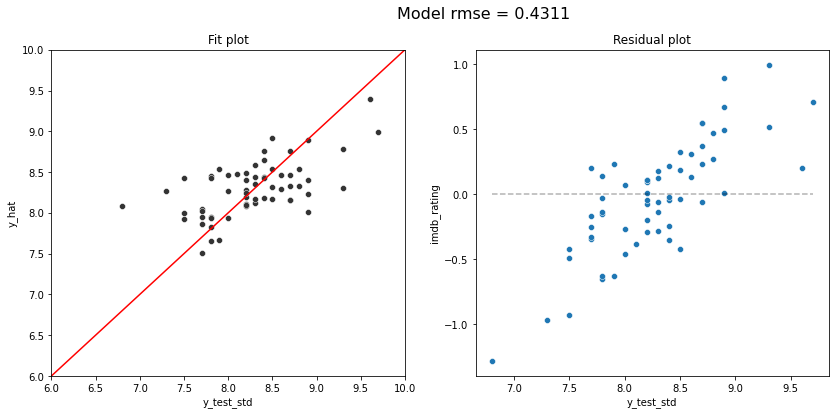

In [167]:
plt.figure(figsize=(12, 6))
        
plt.subplot(121)
plt.axline((1, 1), slope=1,color='r')
sns.scatterplot(x='y_test_std', y='y_hat', data=resid,color=".2").set_title("Fit plot")
plt.xlim([6, 10])   
plt.ylim([6, 10])   


plt.subplot(122)
sns.scatterplot(x='y_test_std', y='imdb_rating', data=resid).set_title("Residual plot")
plt.hlines(y=0, xmin=np.min(y_test_std), xmax=np.max(y_test_std), linestyles='dashed', alpha=0.3, colors="black")
        
plt.subplots_adjust(left=0.0)
    
plt.suptitle("Model rmse = " + str(round(rmse, 4)), fontsize=16)
plt.show()
    

In [168]:
alphas = np.linspace(0, 300, num=200)
ridge_reg = Ridge()
params_Ridge = {'alpha': alphas, "fit_intercept": [True, False], "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
Ridge_GS = GridSearchCV(ridge_reg, param_grid=params_Ridge, n_jobs=-1)
Ridge_GS.fit(X_train_std,y_train_std)
Ridge_GS.best_params_

{'alpha': 40.7035175879397, 'fit_intercept': True, 'solver': 'cholesky'}

In [169]:
Ridgeregression = Ridge(random_state=3, **Ridge_GS.best_params_)
from sklearn.model_selection import cross_val_score
all_accuracies = cross_val_score(estimator=Ridgeregression, X=X_train_std, y=y_train_std, cv=5)
all_accuracies

array([0.50913885, 0.39200695, 0.31368992, 0.58942568, 0.67204718])

In [170]:
Ridgeregression.fit(X_train_std,y_train_std)
Ridgeregression.score(X_test_std,y_test_std)

0.36726136559740197

In [171]:
Ridge_GS.best_estimator_

Ridge(alpha=40.7035175879397, solver='cholesky')

In [172]:
Ridge_GS.best_estimator_.intercept_
Ridge_GS.best_estimator_.coef_

array([[-0.00749789,  0.15229355,  0.01992628, -0.01209774, -0.00233185,
        -0.01696033, -0.01758273,  0.00522134,  0.01506006,  0.02820911,
         0.02400803,  0.00870149, -0.02396608, -0.00358961,  0.01752702,
         0.0256171 ,  0.05197626,  0.00489611,  0.00873455,  0.01326022,
         0.00472661,  0.01253567, -0.06045089, -0.00934607,  0.00321252,
         0.01632941, -0.04041399,  0.00248602,  0.00801522,  0.020871  ,
         0.00713275,  0.0408622 ,  0.0038051 ,  0.00843135,  0.02390319,
         0.01325858, -0.01031388,  0.01128601,  0.00900395,  0.02932406,
         0.02411744,  0.00016945,  0.01081984,  0.01149997, -0.00895583,
         0.00263436, -0.0626473 ,  0.02239043, -0.0286378 ,  0.01710145,
        -0.03403448, -0.01301577,  0.03077995,  0.0213178 ,  0.02105252,
         0.        ,  0.        , -0.00778156,  0.03365577, -0.00434877,
        -0.02083822, -0.02617501,  0.00037322, -0.00017286, -0.01034024,
        -0.01726056,  0.04135744, -0.00220086, -0.0

## 4. Discussion & Conclusions


*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of a NBC Universal executive who is with the show and  university level mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. Your goal should be to convince this audience that your model is both accurate and useful.*

*Finally, you should include concrete recommendations on what NBC Universal should do to make their reunion episode a popular as possible.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*